# Investigating the relation between energy and information

## Work extraction from a generalised Szilard engine

This file contains the code used to reproduce the main figures of my thesis.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import pickle
import math
import string

## Functions

In [2]:
def analytical_predictions(q, N, alpha):
    
    # Probability distribution of particles in a given compartment
    P = p(q, N, alpha) #compute
    P_save.append(P) #save
            
    # Average entropy
    H_mean = - q/N * F(P,N) + math.log(N, 2.0) #compute
            
    # Average work
    W_mean = N * k_b * T * np.log(2) * (H_mean - math.log(q, 2.0)) #compute
    
    return P, W_mean

In [3]:
def p(q,N,alpha): # Probability distribution of particles in a given partition

    P = [[1],[1-1/q, 1/q]] #initial conditions for N=1

    for n in range(1,N):

        p_temp = []

        pn_0 = P[n][0]*(1-alpha/q) #k=0 for n+1 step
        p_temp.extend([pn_0])

        for k in range(1,n+1): # 1 <= k <= n
            pn_ = P[n][k]*(1-alpha/q-(1-alpha)*k/n) + P[n][k-1]*(alpha/q + (1-alpha)*(k-1)/n)
            p_temp.extend([pn_])

        k = n+1
        pn_n = P[n][k-1]*(alpha/q + (1-alpha)*(k-1)/n)
        p_temp.extend([pn_n])

        P.append(p_temp)
        
    return P[N]

In [4]:
def F(P,n): #F function to compute average entropy
    k = np.arange(1, n+1)
    f = sum([x*math.log(x, 2.0)*P[x] for x in k])

    return f

In [5]:
def polya(N, alpha, comp_list_all): # placing particles
    
    K = np.zeros((N,q)) # initialise vector to store number of particles in each partition during Polya's Urn simulations
    comp_list = [] #useful list for random compartment # choice

    comp = random.choice(comp_list_all) #random compartment choice for 1st particle
    comp_list.append(comp)
    K[0, comp] = 1 #place one particle in the 1st chosen compartment at step 0
    
    for pc in range(1,N): #placement of N particles from n>=2
    
        if random.random() <= alpha:
            comp = random.choice(comp_list_all)

        else:
            comp = random.choice(comp_list)

        comp_list.append(comp)

        K[pc, :] = K[pc-1, :] #keep same number of particles for all compartments from previous step
        K[pc, comp] = K[pc-1, comp]+1 #add particle to chosen compartment
    
    return K[-1,:] #keep only last placement arrangement

In [6]:
def initialise_batches():
    
    W_save = [] # batch to save mean work, averaged across trials, for each alpha value
    Werr = [] # errorbar
    K_save = [] # batch to save mean number of particles across compartments, averaged across trials, for each alpha value

    P_save = []
    W_save_th = []
    
    return W_save, Werr, K_save, P_save, W_save_th

In [7]:
def process(trials, N, q, alpha):

    K_temp = [] #batch to save number of particles at each trial
    W_temp = [] #batch to save extracted work at each trial

    for i in range(trials): #multiple trials for each alpha value
                
        K = polya(N, alpha, comp_list_all) # placing particles and storing their number in vector K

        W_temp.append(W(K,N,q)) #computing and saving work W
            
    return W_temp

In [8]:
def W(k,n,Q): #Work
    w = -k_b*T*sum([x*np.log(x*Q/n) for x in k if x > 0])
    
    return w

## Parameters

In [9]:
#Physical constants
k_b = 1 #Boltzmann constant
T = 1 #Temperature

## Figures

### Fig. 4.1

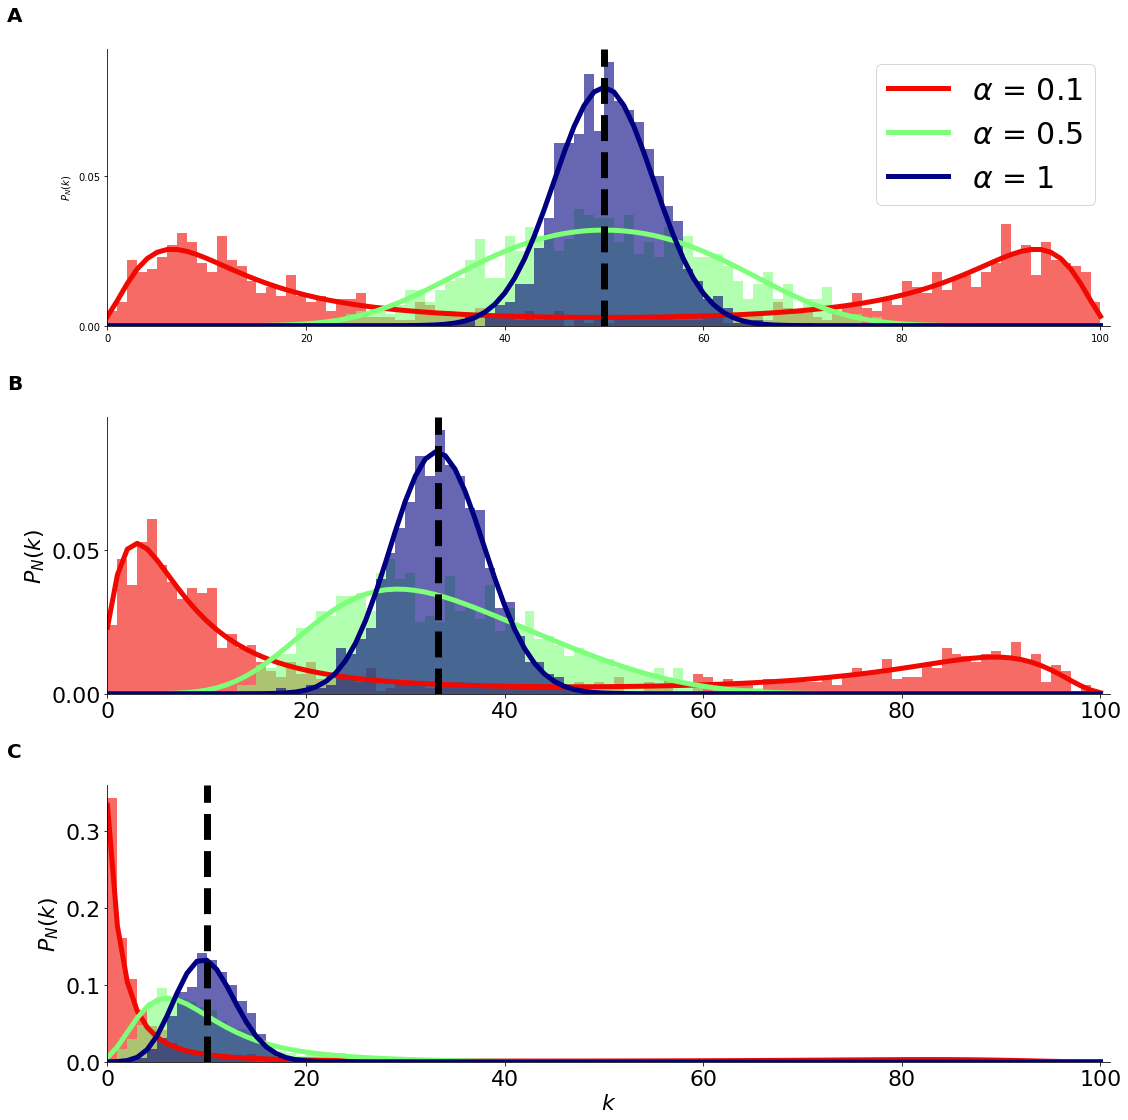

In [10]:
Alpha=[0.1, 0.5, 1]

idxab = [1, 5, 10]

#COLOURS

cm_subsection = np.linspace(1.0, 0.0, 11) 
colors = [ cm.jet(x) for x in cm_subsection ]

q = 2 # number of COMPARTMENTS
N = 100 # total number of particles

# Set distribution of length and number of particles of each compartment according to alpha (0 is uniform, 1 is peaked)
trials = 1000 #trials for each alpha value
comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #

P_save = []

plt.figure(figsize=(16,16))

ax = plt.subplot(311)

for idxa, alpha in enumerate(Alpha):
    
    K_temp = [] #batch to save number of particles at each trial
    W_temp = [] #batch to save extracted work at each trial
    
    for i in range(trials): #multiple trials for each alpha value

        K = np.zeros((N,q)) # initialise vector to store number of particles in each compartment during Polya's Urn simulations
        comp_list = [] #useful list for random compartment # choice

        comp = random.choice(comp_list_all) #random compartment choice for 1st particle
        comp_list.append(comp)
        K[0, comp] = 1 #place one particle in the 1st chosen compartment
    
        for pc in range(1,N): #placing particles

            if random.random() <= alpha:
                comp = random.choice(comp_list_all)
                comp_list.append(comp)
            else:
                comp = random.choice(comp_list)
                comp_list.append(comp)

            K[pc, :] = K[pc-1, :] #keep same number of particles for all compartments from previous step
            K[pc, comp] = K[pc-1, comp]+1 #add particle to chosen compartment
        
        K0 = K[-1,:]
        K_temp.append(K0[0]) #for plotting and saving purposes

    
    #THEORETICAL PREDICTIONS
    
    P, _ = analytical_predictions(q, N, alpha)
    P_save.append(P)
    
    ax.plot(P, color=colors[idxab[idxa]], linewidth=5, label=r'$ \alpha $ = '+str(alpha))
    B = ax.hist(K_temp, bins=np.arange(0,N+1), density=True,
                 color=colors[idxab[idxa]], alpha=.6)

ax.legend(prop={'size': 30})
plt.axvline(x=N/q, color='k', linewidth=7, linestyle='--')

n=0
ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')

plt.rcParams.update({'font.size': 22})

plt.ylabel('$P_{N}(k)$')

# Hide the right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim([0, N+1])
start, end = ax.get_ylim()
stepsize = 0.05
ax.yaxis.set_ticks(np.arange(start, end, stepsize))

############

q = 3 # number of COMPARTMENTS

comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
P_save = []

ax2 = plt.subplot(312)

for idxa, alpha in enumerate(Alpha):
    
    K_temp = [] #batch to save number of particles at each trial
    W_temp = [] #batch to save extracted work at each trial
    
    for i in range(trials): #multiple trials for each alpha value

        K = np.zeros((N,q)) # initialise vector to store number of particles in each compartment during Polya's Urn simulations
        comp_list = [] #useful list for random compartment # choice

        comp = random.choice(comp_list_all) #random compartment choice for 1st particle
        comp_list.append(comp)
        K[0, comp] = 1 #place one particle in the 1st chosen compartment
    
        for pc in range(1,N): #placing particles

            if random.random() <= alpha:
                comp = random.choice(comp_list_all)
                comp_list.append(comp)
            else:
                comp = random.choice(comp_list)
                comp_list.append(comp)

            K[pc, :] = K[pc-1, :] #keep same number of particles for all compartments from previous step
            K[pc, comp] = K[pc-1, comp]+1 #add particle to chosen compartment
        
        K0 = K[-1,:]
        K_temp.append(K0[0]) #for plotting and saving purposesl

    
    #THEORETICAL PREDICTIONS
    
    P, _ = analytical_predictions(q, N, alpha)
    P_save.append(P)
    
    ax2.plot(P, color=colors[idxab[idxa]], linewidth=5)
    C = ax2.hist(K_temp, bins=np.arange(0,N+1), density=True, color=colors[idxab[idxa]], alpha=.6)
    
plt.axvline(x=N/q, color='k', linewidth=7, linestyle='--')

n=1
ax2.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax2.transAxes, size=20, weight='bold')

plt.rcParams.update({'font.size': 22})
plt.xlim([0, N+1])

plt.ylabel('$P_{N}(k)$')

# Hide the right and top spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#plt.legend(prop={'size': 30})
start, end = ax2.get_ylim()
stepsize = 0.05
ax2.yaxis.set_ticks(np.arange(start, end, stepsize))

#######

q = 10 # number of COMPARTMENTS

comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
P_save = []

ax3 = plt.subplot(313)

for idxa, alpha in enumerate(Alpha):
    
    K_temp = [] #batch to save number of particles at each trial
    W_temp = [] #batch to save extracted work at each trial
    
    for i in range(trials): #multiple trials for each alpha value

        K = np.zeros((N,q)) # initialise vector to store number of particles in each compartment during Polya's Urn simulations
        comp_list = [] #useful list for random compartment # choice

        comp = random.choice(comp_list_all) #random compartment choice for 1st particle
        comp_list.append(comp)
        K[0, comp] = 1 #place one particle in the 1st chosen compartment
    
        for pc in range(1,N): #placing particles

            if random.random() <= alpha:
                comp = random.choice(comp_list_all)
                comp_list.append(comp)
            else:
                comp = random.choice(comp_list)
                comp_list.append(comp)

            K[pc, :] = K[pc-1, :] #keep same number of particles for all compartments from previous step
            K[pc, comp] = K[pc-1, comp]+1 #add particle to chosen compartment
        
        K0 = K[-1,:]
        K_temp.append(K0[0]) #for plotting and saving purposes

    
    #THEORETICAL PREDICTIONS
    
    P, _ = analytical_predictions(q, N, alpha)
    P_save.append(P)
    
    ax3.plot(P, color=colors[idxab[idxa]], linewidth=5)
    D = ax3.hist(K_temp, bins=np.arange(0,N+1), density=True, color=colors[idxab[idxa]], alpha=.6)
    
plt.axvline(x=N/q, color='k', linewidth=7, linestyle='--')

n=2
ax3.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax3.transAxes, size=20, weight='bold')

plt.rcParams.update({'font.size': 22})
plt.xlabel('$k$')
plt.ylabel('$P_{N}(k)$')

#ax3b = ax3.twinx()
#ax3b.set_ylabel('$k/N$', color='k')

plt.xlim([0, N+1])
start, end = ax3.get_ylim()
stepsize = 0.1
ax3.yaxis.set_ticks(np.arange(start, end, stepsize))

# Hide the right and top spines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Fig 4.1. The probability of collecting $k$ particles in a given compartment, depending on $\alpha$ and number of compartments. 

Each subplot shows $P_N(k)$ (eq. 3.1) for $\alpha=0.1, \, 0.5, \, 1$, setting $N=100$. In A, $q=2$; in B $q=3$, in C $q=10$. The distribution converges to a unimodal (binomial) distribution centred on $N/q$ (black dashed line) as $\alpha$ grows from 0 to 1 (see also Appendix 7.2.3). As a proof of concept that the sampling from our simulations matched our analytical form for $P_N(k)$, we show a typical histogram of the number of particles in the first compartment, from 1000 trials.

### Fig. 4.2

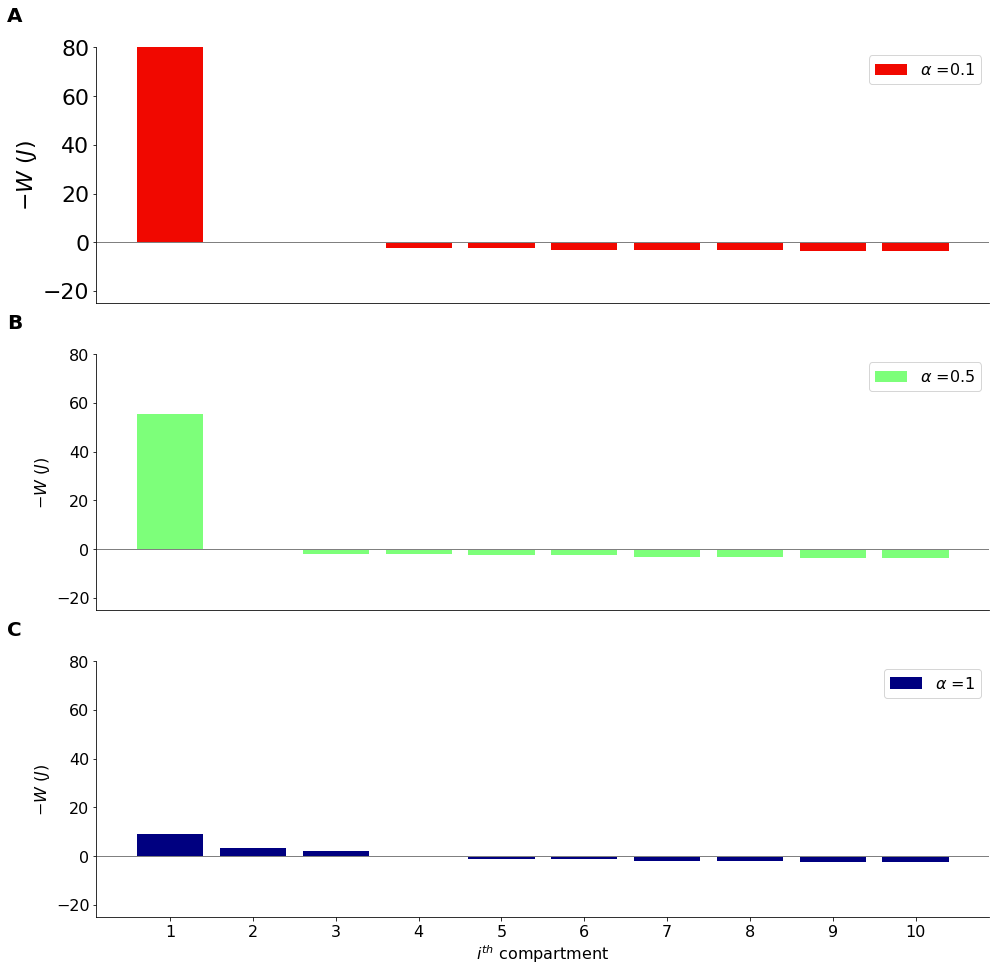

In [11]:
q = 10
N = 100

objects = [str(i) for i in np.arange(1,q+1)]
y_pos = np.arange(len(objects))

comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #

Alpha = [0.1, 0.5, 1]

#COLOURS

cm_subsection = np.linspace(1.0, 0.0, 11) 
colors = [ cm.jet(x) for x in cm_subsection ]
colors = [colors[1], colors[5], colors[10]]

plt.figure(figsize=(16,16))

for j, alpha in enumerate(Alpha):
    
    w = []
    
    K = polya(N, alpha, comp_list_all) # placing particles and storing their number in vector K
    
    for x in K:
        
        if x > 0:
            w.extend([x*np.log(x*q/N)])
        else:
            w.extend([0])
            
    w = np.sort(w)[::-1]
    
    ax = plt.subplot(3,1,j+1)
    
    plt.rcParams.update({'font.size': 16})

    plt.bar(y_pos, w, align='center', color=colors[j], label=r'$ \alpha $ ='+str(alpha))
    
    plt.ylabel('$-W$ '+'$ (J)$')
    
    ax.text(-0.1, 1.1, string.ascii_uppercase[j], transform=ax.transAxes, size=20, weight='bold')
    ax.axhline(y=0, color=[.5, .5, .5], linewidth=1)
    
    if j==len(Alpha)-1:
        plt.xticks(y_pos, objects)
        plt.xlabel('$i^{th}$ compartment')
    else:
        plt.xticks([])

    # Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylim([-25, 80])
    ax.legend()

plt.show()

#### Fig. 4.2. Example of work extracted $-W$ from each compartment in a single trial from three different initial conditions.

In A, from far-from-equilibrium conditions ($\alpha = 0.1$), the work extracted comes mainly from one compartment. In B and C, as a increases ($\alpha = 0.5$ and $\alpha = 1$), the work extracted tends to be uniform across compartments. These simulations were run setting $q = 10$ and $N = 100$. The initial particle distributions are shown in Fig. 4.1C. In each subplot, the work extracted from each compartment was sorted in
decreasing order for visual purposes.

### Fig. 4.3

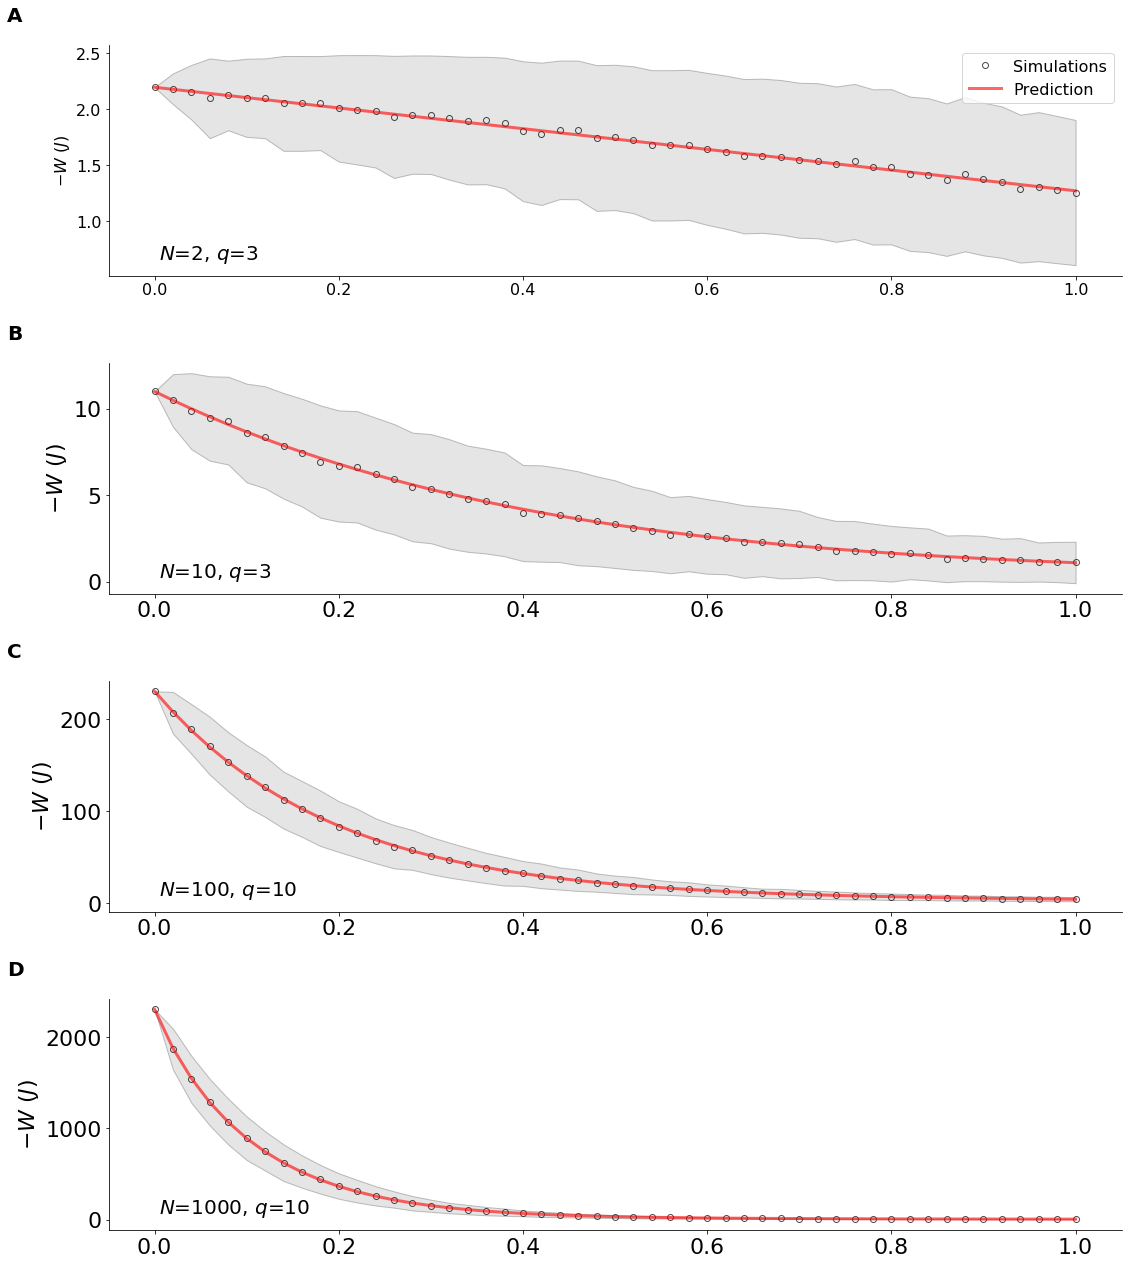

In [12]:
# Parameters for serial analysis
compartments = [3] # number of walls for serial analysis
particles = [2] # total number of particles for serial analysis

# Paramteres for Polya's Urn simulations
trials = 1000 # trials for each alpha value
alpha_res = 51 # number of alpha values between 0 and 1; it determines the resolution of the plots
Alpha = np.linspace(0,1,alpha_res) # Polya Urn's parameter ranging between 0 and 1

# COMPUTATIONS

plt.figure(figsize=(16,18))

for idxq, q in enumerate(compartments): # for each number of compartments
    
    comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
    
    for idxN, N in enumerate(particles): # for each number of particles

        # initialise batches
        W_save, Werr, K_save, P_save, W_save_th = initialise_batches()
        
        # POLYA'S URN
        for alpha in Alpha: # test different alpha values
            
            # SIMULATIONS
            W_temp = process(trials, N, q, alpha) #compute work for all trials
            W_save.append(np.mean(W_temp)) #save mean work
            Werr.append(np.std(W_temp)) #save SD
            
            # ANALYTICAL PREDICTIONS
            P, W_mean = analytical_predictions(q, N, alpha)
            P_save.append(P), W_save_th.append(W_mean)     

n=0
ax = plt.subplot(411)

ax.plot(Alpha, [-i for i in W_save], color='k', alpha=.7, label='Simulations', marker='o',
           fillstyle='none', linestyle='none')
ax.fill_between(Alpha, [-a_i-b_i for a_i, b_i in zip (W_save, Werr)],
                [-a_i+b_i for a_i, b_i in zip (W_save, Werr)],
                alpha=.5, edgecolor='#808080', facecolor=[.8, .8, .8])
ax.plot(Alpha, [-i for i in W_save_th], color='r', alpha=.6, linewidth=3, label='Prediction')

ax.set_ylabel('$-W$'+' $(J)$')
ax.legend()

plt.rcParams.update({'font.size': 22})

ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
ax.text(0.05, 0.07, '$N$='+str(N)+', $q$='+str(q), transform=ax.transAxes, size=20)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


########

# Parameters for serial analysis
compartments = [3] # number of walls for serial analysis
particles = [10] # total number of particles for serial analysis

# Paramteres to evaluate max average extracted work from simulations
W_max = np.zeros((len(compartments), len(particles)))
W_maxerr = np.zeros((len(compartments), len(particles)))

for idxq, q in enumerate(compartments): # for each number of compartments
    
    comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
    
    for idxN, N in enumerate(particles): # for each number of particles

        # initialise batches
        W_save, Werr, K_save, P_save, W_save_th = initialise_batches()
        
        # POLYA'S URN
        for alpha in Alpha: # test different alpha values
            
            # SIMULATIONS
            W_temp = process(trials, N, q, alpha) #compute work for all trials
            W_save.append(np.mean(W_temp)) #save mean work
            Werr.append(np.std(W_temp)) #save SD
            
            # ANALYTICAL PREDICTIONS
            P, W_mean = analytical_predictions(q, N, alpha)
            P_save.append(P), W_save_th.append(W_mean)

n=1
ax2 = plt.subplot(412)

ax2.plot(Alpha, [-i for i in W_save], color='k', alpha=.7, label='Simulations', marker='o',
           fillstyle='none', linestyle='none')
ax2.fill_between(Alpha, [-a_i-b_i for a_i, b_i in zip (W_save, Werr)],
                [-a_i+b_i for a_i, b_i in zip (W_save, Werr)],
                alpha=.5, edgecolor='#808080', facecolor=[.8, .8, .8])
ax2.plot(Alpha, [-i for i in W_save_th], color='r', alpha=.6, linewidth=3, label='Prediction')
ax2.set_ylabel('$-W$'+' $(J)$')

plt.rcParams.update({'font.size': 22})

ax2.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax2.transAxes, size=20, weight='bold')
ax2.text(0.05, 0.07, '$N$='+str(N)+', $q$='+str(q), transform=ax2.transAxes, size=20)

# Hide the right and top spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


########

# Parameters for serial analysis
compartments = [10] # number of walls for serial analysis
particles = [100] # total number of particles for serial analysis

# Paramteres to evaluate max average extracted work from simulations
W_max = np.zeros((len(compartments), len(particles)))
W_maxerr = np.zeros((len(compartments), len(particles)))

for idxq, q in enumerate(compartments): # for each number of compartments
    
    comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
    
    for idxN, N in enumerate(particles): # for each number of particles

        # initialise batches
        W_save, Werr, K_save, P_save, W_save_th = initialise_batches()
        
        # POLYA'S URN
        for alpha in Alpha: # test different alpha values
            
            # SIMULATIONS
            W_temp = process(trials, N, q, alpha) #compute work for all trials
            W_save.append(np.mean(W_temp)) #save mean work
            Werr.append(np.std(W_temp)) #save SD
            
            # ANALYTICAL PREDICTIONS
            P, W_mean = analytical_predictions(q, N, alpha)
            P_save.append(P), W_save_th.append(W_mean)

            
n=2
ax3 = plt.subplot(413)

ax3.plot(Alpha, [-i for i in W_save], color='k', alpha=.7, label='Simulations', marker='o',
           fillstyle='none', linestyle='none')
ax3.fill_between(Alpha, [-a_i-b_i for a_i, b_i in zip (W_save, Werr)],
                [-a_i+b_i for a_i, b_i in zip (W_save, Werr)],
                alpha=.5, edgecolor='#808080', facecolor=[.8, .8, .8])
ax3.plot(Alpha, [-i for i in W_save_th], color='r', alpha=.6, linewidth=3, label='Prediction')
ax3.set_ylabel('$-W$'+' $(J)$')

plt.rcParams.update({'font.size': 22})

ax3.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax3.transAxes, size=20, weight='bold')
ax3.text(0.05, 0.07, '$N$='+str(N)+', $q$='+str(q), transform=ax3.transAxes, size=20)

# Hide the right and top spines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


########

# Parameters for serial analysis
compartments = [10] # number of walls for serial analysis
particles = [1000] # total number of particles for serial analysis

for idxq, q in enumerate(compartments): # for each number of compartments
    
    comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
    
    for idxN, N in enumerate(particles): # for each number of particles

        # initialise batches
        W_save, Werr, K_save, P_save, W_save_th = initialise_batches()
        
        # POLYA'S URN
        for alpha in Alpha: # test different alpha values
            
            # SIMULATIONS
            W_temp = process(trials, N, q, alpha) #compute work for all trials
            W_save.append(np.mean(W_temp)) #save mean work
            Werr.append(np.std(W_temp)) #save SD
            
            # ANALYTICAL PREDICTIONS
            P, W_mean = analytical_predictions(q, N, alpha)
            P_save.append(P), W_save_th.append(W_mean)

n=3
ax4 = plt.subplot(414)

ax4.plot(Alpha, [-i for i in W_save], color='k', alpha=.7, label='Simulations', marker='o',
           fillstyle='none', linestyle='none')
ax4.fill_between(Alpha, [-a_i-b_i for a_i, b_i in zip (W_save, Werr)],
                [-a_i+b_i for a_i, b_i in zip (W_save, Werr)],
                alpha=.5, edgecolor='#808080', facecolor=[.8, .8, .8])
ax4.plot(Alpha, [-i for i in W_save_th], color='r', alpha=.6, linewidth=3, label='Prediction')
ax4.set_ylabel('$-W$'+' $(J)$')

plt.rcParams.update({'font.size': 22})

ax4.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax4.transAxes, size=20, weight='bold')
ax4.text(0.05, 0.07, '$N$='+str(N)+', $q$='+str(q), transform=ax4.transAxes, size=20)

# Hide the right and top spines
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Fig. 4.3: Average work extracted $-\langle W \rangle$ depending on the particle distribution, from far-fromequilibrium ($\alpha = 0$) to equilibrium initial states ($\alpha = 1$).

Each subplot compares average work extracted from theoretical predictions (eq. 3.5, red line) with the
results from simulations. For our simulations, we plot the mean $\pm$ SD on 1000 trials (black circles with
grey shading). Subplots differ by number of particles ($N$) and compartments ($q$), specified at the bottom-left
corner of each plot. The y-axis scales with $q$ and $N$. For more details about the particle distribution
$P_N(\vec{k})$ across compartments and its parameter a, see section 3.2, eq. 3.1 and Fig. 4.1.

### Fig. 4.4

In [13]:
# Parameters for serial analysis
compartments = [2] # number of walls for serial analysis
particles = np.arange(1, 51)

# Paramteres for Polya's Urn simulations
alpha_res = 11 # number of alpha values between 0 and 1; it determines the resolution of the plots
Alpha = np.linspace(0,1,alpha_res) # Polya Urn's parameter ranging between 0 and 1

W = np.zeros((len(compartments), len(Alpha), len(particles) ))

# COMPUTATIONS

for idxq, q in enumerate(compartments): # for each number of compartments
        
    # POLYA'S URN
    for idxa, alpha in enumerate(Alpha): # test different alpha values
                  
        for idxN, N in enumerate(particles): # for each number of particles
            
            # ANALYTICAL PREDICTIONS
            P, W_mean = analytical_predictions(q, N, alpha)
            W[idxq, idxa, idxN] = W_mean 

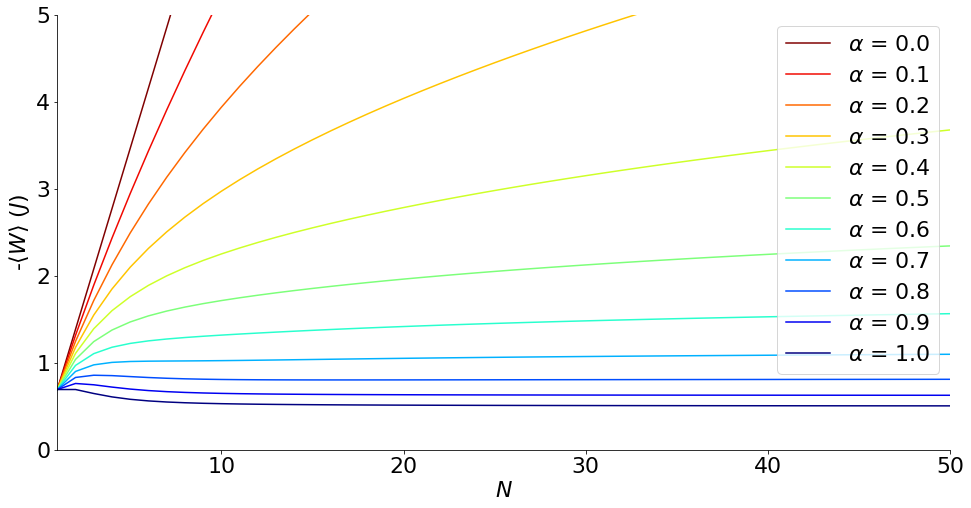

In [14]:
#COLOURS

cm_subsection = np.linspace(1.0, 0.0, len(Alpha)) 
colors = [ cm.jet(x) for x in cm_subsection ]

plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1)

for idxa, alpha in enumerate(Alpha):
    plt.plot(particles, -W[0,idxa,:], color=colors[idxa],
             label=r'$ \alpha $ = '+str(round(alpha, 1)))

plt.xlabel('$N$')
ax.set_ylabel('-'+r'$\langle W \rangle$'+' $(J)$')

plt.legend(loc=1)
plt.xlim([1, 50])
plt.ylim([0, 5])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.rcParams.update({'font.size': 22})

plt.show()

#### Fig 4.4: The growing trend of the average work extracted $-\langle W \rangle$, as the the total number of particles $N$ grows, for different initial particle distributions.

Each curve represents the trend for a different initial state, ranging between equilibrium ($\alpha = 1$) and
maximal non-equilibrium ($\alpha = 0$). The average work extracted was computed from the theoretical
predictions (eq. 3.5), setting $q = 2$ as an example. Results were compared with simulation as in Fig. 4.3.

### Fig 4.5

In [15]:
### SIMULATIONS

# Parameters for serial analysis
compartments = [2, 100, 1000] # number of walls for serial analysis
particles = [1000]

# Paramteres for Polya's Urn simulations
alpha_res = 51 # number of alpha values between 0 and 1; it determines the resolution of the plots
Alpha = np.linspace(0,1,alpha_res) # Polya Urn's parameter ranging between 0 and 1

W = np.zeros((len(compartments), len(Alpha), len(particles) ))

# COMPUTATIONS

for idxq, q in enumerate(compartments): # for each number of compartments
        
    # POLYA'S URN
    for idxa, alpha in enumerate(Alpha): # test different alpha values
                  
        for idxN, N in enumerate(particles): # for each number of particles
            
            # ANALYTICAL PREDICTIONS
            P, W_mean = analytical_predictions(q, N, alpha)
            W[idxq, idxa, idxN] = -W_mean

In [16]:
### MEASURE H[k]

Hk = np.zeros((len(compartments), len(Alpha)))
trials = 1000

for idxq, q in enumerate(compartments):
    
    comp_list_all = (np.arange(q)).tolist() #useful list with all the compartment #
    K0 = np.zeros((alpha_res, trials, q)) #batch to save mean number of particles across compartments, averaged across trials, for each alpha value
    
    for idxa, alpha in enumerate(Alpha): #test different alpha values

        for i in range(trials): #multiple trials for each alpha value

            K = np.zeros((N,q)) # initialise vector to store number of particles in each compartment during Polya's Urn simulations
            comp_list = [] #useful list for random compartment # choice

            comp = random.choice(comp_list_all) #random compartment choice for 1st particle
            comp_list.append(comp)
            K[0, comp] = 1 #place one particle in the 1st chosen compartment

            for pc in range(1,N): #placing particles

                if random.random() <= alpha:
                    comp = random.choice(comp_list_all)
                    comp_list.append(comp)
                else:
                    comp = random.choice(comp_list)
                    comp_list.append(comp)

                K[pc, :] = K[pc-1, :] #keep same number of particles for all compartments from previous step
                K[pc, comp] = K[pc-1, comp]+1 #add particle to chosen compartment

            K0[idxa, i, :] = K[-1,:]
    
    #H[k]

    hk = np.zeros((len(Alpha), trials))
    m = np.zeros((len(Alpha), trials, N+1))

    for idxa in range(len(Alpha)):

        for j in range(trials):

            hhk = 0

            A = [int(x) for x in K0[idxa, j, :]]    

            m[idxa, j, :], bins = np.histogram(A, bins=np.arange(0,N+2)-0.5, density=False)

            for k in range(1,N+1):

                if m[idxa, j, k] > 0:

                    hhk = hhk + k*m[idxa, j, k]/N * math.log(k*m[idxa, j, k]/N, 2)

            hk[idxa, j] = - hhk

    Hk[idxq, :] = np.mean(hk, axis=1)

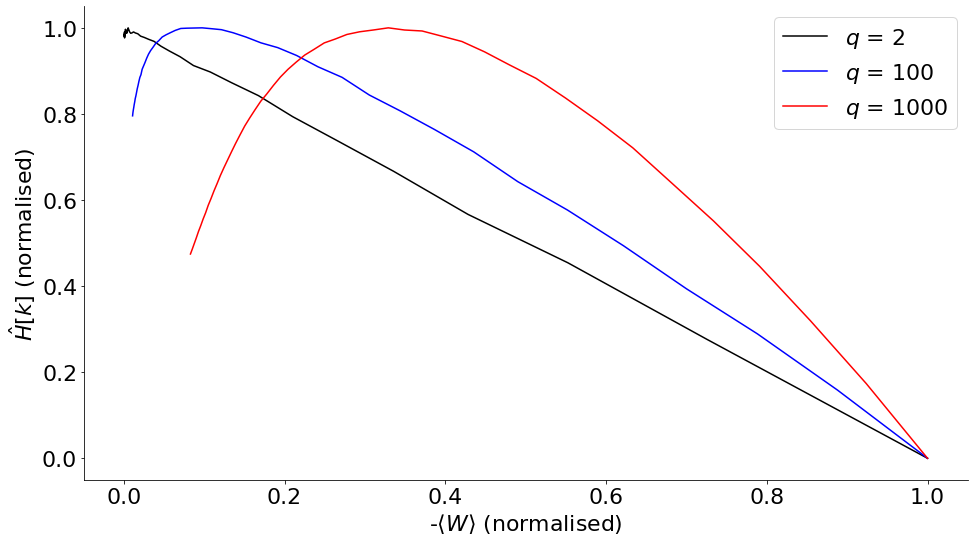

In [17]:
#PLOT

cl = ['k', 'b', 'r']

plt.figure(figsize=(14,8))
plt.rcParams.update({'font.size': 22})

ax = plt.subplot(111)

for idxq, q in enumerate(compartments):
    
    w = W[idxq, :, 0]
    h = Hk[idxq,:]
    
    plt.plot(w/np.max(w), h/np.max(h), color=cl[idxq], label='$q$ = '+str(q))
    plt.ylabel(r'$\hat{H}[k]$ (normalised)')
    
    if idxq == len(compartments)-1:
        ax.set_xlabel('-'+r'$\langle W \rangle$'+' (normalised)')
    plt.legend()
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()
plt.show()

#### Fig. 4.5. Average work extracted $-\langle W \rangle$ and average relevance $\hat{H}[k]$.

For our simualtions we set $N = 1000$, with $q = 2, 100, 1000$, as an example. The average work extracted
$\langle W \rangle$ was computed from the theoretical predictions (eq. 3.5). $\hat{H}[k]$ was averaged over 1000 trials. For
plotting purposes, we normalised both $-\langle W \rangle$  and $\hat{H}[k]$ over their maximum value for each $q$.